### **Finding Best Feature Extraction:**


   

Best models on CIFAR dataset: https://paperswithcode.com/sota/image-classification-on-cifar-10

    # "EfficientNet-B0": torchvision_models.efficientnet_b0(pretrained=True), #79.88%
    # "ViT-Base": timm.create_model('vit_base_patch16_224', pretrained=True), #84.68%
    # "Swin-Transformer": timm.create_model('swin_base_patch4_window7_224', pretrained=True), #0.24%
    # "AlexNet": torchvision_models.alexnet(pretrained=True),  # 57.36%
    # "ResNet50": torchvision_models.resnet50(pretrained=True),  # 63.52%

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models as torchvision_models
import timm
from sklearn.metrics import accuracy_score
import numpy as np

# Load your dataset
t = torch.load(r'/content/drive/MyDrive/ML_Mini_Project_2/dataset/dataset/part_one_dataset/train_data/1_train_data.tar.pth')
data, targets = t['data'], t['targets']
data = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)
targets = torch.tensor(targets, dtype=torch.long)

# Define the transformations including resizing
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL image
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Apply the transformations to your data
data = torch.stack([transform(img) for img in data])

# DataLoader
dataset = TensorDataset(data, targets)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# Function to extract features
def extract_features(model, loader):
    model.eval()
    features = []
    with torch.no_grad():
        for inputs, _ in loader:
            feature_vectors = model(inputs)
            features.append(feature_vectors)
    return torch.cat(features)


# Define models and remove classification layers
models = {
    # "EfficientNet-B3": timm.create_model('tf_efficientnet_b3_ns', pretrained=True),  #69.76%
    # "VGG16": torchvision_models.vgg16(pretrained=True),  # 60.72%
    "DPN92": timm.create_model('dpn92', pretrained=True),  #
    # "AlexNet": torchvision_models.alexnet(pretrained=True),  # 57.36%
    # "ResNet50": torchvision_models.resnet50(pretrained=True),  # 63.52%
    # "ResNet101": torchvision_models.resnet101(pretrained=True),  # 67.32%
    # "DenseNet121": torchvision_models.densenet121(pretrained=True), #63.96%
    # "RegNetY-400MF": torchvision_models.regnet_y_400mf(pretrained=True), #64.00%
    "SENet154": timm.create_model('senet154', pretrained=True),
    "MobileNetV2": torchvision_models.mobilenet_v2(pretrained=True),  # New model added
    "InceptionV3": torchvision_models.inception_v3(pretrained=True),  # Use default aux_logits=True
    # "EfficientNet-B0": torchvision_models.efficientnet_b0(pretrained=True), #79.88%
    # "ViT-Base": timm.create_model('vit_base_patch16_224', pretrained=True), #84.68%
    # "Swin-Transformer": timm.create_model('swin_base_patch4_window7_224', pretrained=True), #0.24%
    "ConvNeXt-Base": torchvision_models.convnext_base(pretrained=True)
}

# Remove the last classification layer for each model to get feature vectors
for model_name, model in models.items():
    if 'ResNet' in model_name:
        model.fc = torch.nn.Identity()  # For ResNet models
    elif 'MobileNet' in model_name:
        model.classifier[1] = torch.nn.Identity()  # For MobileNet models
    elif 'VGG' in model_name:
        model.classifier[6] = torch.nn.Identity()  # For VGG models
    elif 'Inception' in model_name:
        model.fc = torch.nn.Identity()  # For Inception models
    elif 'AlexNet' in model_name:
        model.classifier[6] = torch.nn.Identity()  # For AlexNet model
    else:
        if model_name == "EfficientNet-B3":
            model.classifier = torch.nn.Identity()
        elif model_name == "DPN92":
            model.classifier = torch.nn.Identity()
        elif model_name == "EfficientNet-B0":
            model.classifier = torch.nn.Identity()
        elif model_name == "ViT-Base":
            model.head = torch.nn.Identity()
        elif model_name == "Swin-Transformer":
            model.head = torch.nn.Identity()
        elif model_name == "ConvNeXt-Base":
            model.classifier[2] = torch.nn.Identity()
        elif model_name == "DenseNet121":
            model.classifier = torch.nn.Identity()
        elif model_name == "RegNetY-400MF":
            model.fc = torch.nn.Identity()
        elif model_name == "SENet154":
            model.fc = torch.nn.Identity()


<ipython-input-7-8abb8309ab0a>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t = torch.load(r'/content/drive/MyDrive/ML_Mini_Project_2/dataset/dataset/part_one_dataset/t

In [ ]:
# Apply LwP and calculate accuracy
for model_name, model in models.items():
    print(f"\nExtracting features and applying LwP using {model_name}...")

    # Feature extraction
    features = extract_features(model, loader)
    features = features.numpy()

    # Prototype calculation (mean feature vector per class)
    num_classes = len(torch.unique(targets))
    prototypes = []
    for i in range(num_classes):
        class_features = features[targets == i]
        prototype = class_features.mean(axis=0)
        prototypes.append(prototype)
    prototypes = np.array(prototypes)

    # LwP Classification using Euclidean distance
    predictions = []
    for feature in features:
        distances = np.linalg.norm(prototypes - feature, axis=1)
        predicted_class = np.argmin(distances)
        predictions.append(predicted_class)

    # Calculate accuracy
    accuracy = accuracy_score(targets.numpy(), predictions)
    print(f"Accuracy with {model_name}: {accuracy * 100:.2f}%")


Extracting features and applying LwP using VGG16...
Accuracy with VGG16: 60.72%

Extracting features and applying LwP using DPN92...


KeyboardInterrupt: 

### **Code To Extract Features from Vision-Transformer PreTrained Base Model:**

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Load weights and preprocessing transforms
weights = ViT_B_16_Weights.DEFAULT
preprocess = weights.transforms()

print(preprocess)


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import timm
import pickle
import os
from torchvision.transforms import InterpolationMode

# Load dataset
t = torch.load(r'/content/drive/MyDrive/ML_Mini_Project_2/dataset/dataset/part_one_dataset/eval_data/9_eval_data.tar.pth')
data, targets = t['data'], t['targets']
data = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)
targets = torch.tensor(targets, dtype=torch.long)

#  transformations for ViT
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL image
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply the transformations to your data
data = torch.stack([transform(img) for img in data])
dataset = TensorDataset(data, targets)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# Function to extract features
def extract_features(model, loader):
    model.eval()
    features = []
    with torch.no_grad():
        for inputs, _ in loader:
            feature_vectors = model(inputs)
            features.append(feature_vectors)
    return torch.cat(features)

# Load the ViT-Base model and remove the classification layer
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = torch.nn.Identity()  # Remove the classification layer

# Extract features
print("Extracting features using ViT-Base...")
features = extract_features(model, loader)
features = features.numpy()

# Save features and targets using pickle
output_path = r'/content/drive/MyDrive/ML_Mini_Project_2/dataset/extracted_features_9_data.tar.pkl'

# Check if output directory exists, if not create it
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, 'wb') as f:
    pickle.dump({'features': features, 'targets': targets}, f)
print(f"Features and prototypes saved to {output_path}")

# Load features and prototypes using pickle
with open(output_path, 'rb') as f:
    loaded_data = pickle.load(f)
    loaded_features = loaded_data['features']
    loaded_targets = loaded_data['targets']
    print("Features land targets loaded successfully.")

print(f"Loaded features shape: {loaded_features.shape}")
print(f"Loaded targets shape: {loaded_targets.shape}")


<ipython-input-4-c04ef537a54f>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t = torch.load(r'/content/drive/MyDrive/ML_Mini_Project_2/dataset/dataset/part_one_dataset/e

Extracting features using ViT-Base...
Features and prototypes saved to /content/drive/MyDrive/ML_Mini_Project_2/dataset/extracted_features_9_data.tar.pkl
Features land targets loaded successfully.
Loaded features shape: (2500, 768)
Loaded targets shape: torch.Size([2500])


### **LWP with Euclidean distance only on D1:**

In [ ]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
import pickle

output_path = r'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_1_data.tar.pkl'
with open(output_path, 'rb') as f:
    loaded_data = pickle.load(f)
    features = loaded_data['features']
    targets = loaded_data['targets']
    targets = torch.tensor(targets, dtype=torch.long)

# Prototype calculation (mean feature vector per class)
num_classes = 10
prototypes = []
for i in range(num_classes):
    class_features = features[targets == i]
    prototype = class_features.mean(axis=0)
    prototypes.append(prototype)
prototypes = np.array(prototypes)

# LwP Classification using Euclidean distance
predictions = []
for feature in features:
    distances = np.linalg.norm(prototypes - feature, axis=1)
    predicted_class = np.argmin(distances)
    predictions.append(predicted_class)

# Calculate accuracy
accuracy = accuracy_score(targets.numpy(), predictions)
print(f"Accuracy with ViT-Base: {accuracy * 100:.2f}%")

Accuracy with ViT-Base: 83.84%


<ipython-input-5-1117afd6608a>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.long)


### **Soft LWP on D1:**

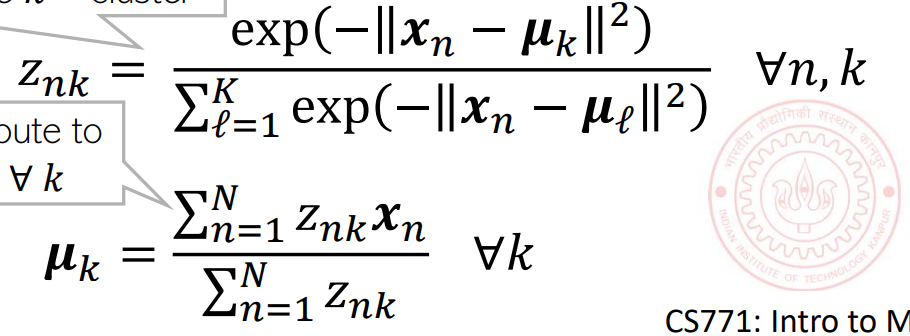

In [ ]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
import pickle

output_path = r'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_1_data.tar.pkl'
with open(output_path, 'rb') as f:
    loaded_data = pickle.load(f)
    features = loaded_data['features']
    targets = loaded_data['targets']
    targets = torch.tensor(targets, dtype=torch.long)

# Number of classes and prototypes initialization
num_classes = 10
prototypes = []

# Prototype calculation using the formula from the image
for k in range(num_classes):
    class_features = features[targets == k]

    # Calculate softmax weights based on distances
    distances = np.linalg.norm(class_features - class_features.mean(axis=0), axis=1)
    weights = np.exp(-distances) / np.sum(np.exp(-distances))

    # Calculate weighted mean as the prototype for each class
    prototype = np.sum(weights[:, np.newaxis] * class_features, axis=0) / np.sum(weights)
    prototypes.append(prototype)

prototypes = np.array(prototypes)

# LwP Classification using Euclidean distance
predictions = []
for feature in features:
    distances = np.linalg.norm(prototypes - feature, axis=1)
    predicted_class = np.argmin(distances)
    predictions.append(predicted_class)

# Calculate accuracy
accuracy = accuracy_score(targets.numpy(), predictions)
print(f"Accuracy of soft LWP: {accuracy * 100:.2f}%")


Accuracy of soft LWP: 74.04%


<ipython-input-6-2d8b98aae39c>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.long)


### **LWP with learned mahalanobis distance only on D1:**


In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import pickle

# Load data
output_path = r'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_1_data.tar.pkl'
with open(output_path, 'rb') as f:
    loaded_data = pickle.load(f)
    features = loaded_data['features']
    targets = loaded_data['targets']
    targets = torch.tensor(targets, dtype=torch.long)

# Prototype calculation (mean feature vector per class)
num_classes = 10
prototypes = []
cov_matrices = []

for i in range(num_classes):
    class_features = features[targets == i]
    prototype = class_features.mean(axis=0)
    prototypes.append(prototype)
    # Calculate the covariance matrix and its inverse
    cov_matrix = np.cov(class_features, rowvar=False) + np.eye(class_features.shape[1]) * 1e-6  # add a small value to avoid singularity
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    cov_matrices.append(inv_cov_matrix)  # store the inverse covariance matrix for Mahalanobis distance

prototypes = np.array(prototypes)
# Mahalanobis Distance Classification
predictions = []
for feature in features:
    distances = []
    for i in range(num_classes):
        diff = feature - prototypes[i]
        mah_dist = np.sqrt(diff.T @ cov_matrices[i] @ diff)
        distances.append(mah_dist)
    predicted_class = np.argmin(distances)
    predictions.append(predicted_class)

# Calculate accuracy
accuracy = accuracy_score(targets.numpy(), predictions)
print(f"Accuracy OF lwp with LEARNED Mahalanobis Distance: {accuracy * 100:.2f}%")


<ipython-input-7-8e064b25547b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.long)


Accuracy OF lwp with LEARNED Mahalanobis Distance: 100.00%


### **Task-1 Complete Implementation:**

In [ ]:
import torch
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import pickle

class LwPClassifier:
    def __init__(self):
        self.prototypes = {}

    def fit(self, features, labels):
        # Calculate class prototypes as mean of features per class
        for cls in np.unique(labels):
            cls_features = features[labels == cls]
            prototype = cls_features.mean(axis=0)
            self.prototypes[cls] = prototype

    def predict(self, features):
        # Calculate Euclidean distance between features and each class prototype
        dists = euclidean_distances(features, list(self.prototypes.values()))
        preds = np.argmin(dists, axis=1)  # Class with the closest prototype
        # Calculate confidence scores as inverse distances
        min_dists = np.min(dists, axis=1)
        confidence_scores = 1 / (1 + min_dists)  # Higher distance means lower confidence
        return np.array(list(self.prototypes.keys()))[preds], confidence_scores

    def update_prototype(self, features, pseudo_labels, confidence_scores, threshold=0.7):
        # Update prototypes with high-confidence pseudo-labeled data
        for cls in np.unique(pseudo_labels):
            high_conf_indices = np.where((pseudo_labels == cls) & (confidence_scores >= threshold))[0]
            #print(high_conf_indices)
            if len(high_conf_indices) > 0:
                cls_features = features[high_conf_indices]
                #print(cls_features)
                # Update prototype by averaging with new data
                self.prototypes[cls] = (self.prototypes[cls] + cls_features.mean(axis=0))

# Load and initialize model on D1
models = []  # List to store models after each update
output_path = r'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_1_data.tar.pkl'
with open(output_path, 'rb') as f:
    loaded_data = pickle.load(f)
    features_D1 = loaded_data['features']
    targets = loaded_data['targets']

# Train LwP classifier on D1 and save as the first model
lwp_classifier = LwPClassifier()
lwp_classifier.fit(features_D1, targets)
models.append(lwp_classifier.prototypes.copy())  # Save a copy of the prototypes as model 1

# Iterate from D2 to D10, updating and saving each model
for i in range(2, 11):
    output_path = fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl'
    with open(output_path, 'rb') as f:
        loaded_data = pickle.load(f)
        features_Di = loaded_data['features']

    # Predict labels and confidence scores for Di
    pseudo_labels, confidence_scores = lwp_classifier.predict(features_Di)

    # Update model using high-confidence predictions
    lwp_classifier.update_prototype(features_Di, pseudo_labels, confidence_scores, threshold=0.06)

    # Save the updated model (prototypes) after each dataset
    models.append(lwp_classifier.prototypes.copy())

# Evaluate each saved model on the appropriate held-out datasets
accuracy_matrix = np.zeros((10, 10))  # 10 models x 10 held-out datasets

# Loop over each model and evaluate on datasets up to the current model
for i, model_prototypes in enumerate(models):
    # Load up to the i-th dataset for evaluation
    for j in range(i + 1):
        output_path = fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{j+1}_data.tar.pkl'
        with open(output_path, 'rb') as f:
            loaded_data = pickle.load(f)
            held_out_features = loaded_data['features']
            held_out_targets = loaded_data['targets']

        # Ensure held_out_targets is a NumPy array for compatibility
        held_out_targets = held_out_targets.numpy() if isinstance(held_out_targets, torch.Tensor) else held_out_targets

        # Predict using the current model's prototypes
        dists = euclidean_distances(held_out_features, list(model_prototypes.values()))
        preds = np.array(list(model_prototypes.keys()))[np.argmin(dists, axis=1)]

        # Calculate accuracy
        accuracy = np.mean((preds == held_out_targets).astype(float))
        accuracy_matrix[i, j] = accuracy

print("Accuracy Matrix:")
print(accuracy_matrix)

Accuracy Matrix:
[[0.8384 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.8384 0.8388 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.8384 0.8388 0.8404 0.     0.     0.     0.     0.     0.     0.    ]
 [0.8384 0.8388 0.8404 0.85   0.     0.     0.     0.     0.     0.    ]
 [0.8384 0.8388 0.8404 0.85   0.8424 0.     0.     0.     0.     0.    ]
 [0.8384 0.8388 0.8404 0.85   0.8424 0.8388 0.     0.     0.     0.    ]
 [0.8384 0.8388 0.8404 0.85   0.8424 0.8388 0.8344 0.     0.     0.    ]
 [0.8384 0.8388 0.8404 0.85   0.8424 0.8388 0.8344 0.8492 0.     0.    ]
 [0.8384 0.8388 0.8404 0.85   0.8424 0.8388 0.8344 0.8492 0.826  0.    ]
 [0.8384 0.8388 0.8404 0.85   0.8424 0.8388 0.8344 0.8492 0.826  0.8504]]


In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import pickle

# Helper function to load data
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    features = data['features']
    if 'targets' in data:  # Labeled data
        targets = data['targets']
        targets = targets.clone().detach() if isinstance(targets, torch.Tensor) else torch.tensor(targets,dtype=torch.long)
    else:  # Unlabeled data
        targets = None
    return features, targets

# LwP model training and prediction function
def train_lwp(features, targets):
    num_classes = 10
    prototypes = []
    cov_matrices = []
    for i in range(num_classes):
        class_features = features[targets == i]
        prototype = class_features.mean(axis=0)
        prototypes.append(prototype)
        cov_matrix = np.cov(class_features, rowvar=False) + np.eye(class_features.shape[1]) * 1e-6
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        cov_matrices.append(inv_cov_matrix)

    return np.array(prototypes), cov_matrices

def predict_lwp(features, prototypes, cov_matrices):
    predictions = []
    for feature in features:
        distances = []
        for i in range(len(prototypes)):
            diff = feature - prototypes[i]
            mah_dist = np.sqrt(diff.T @ cov_matrices[i] @ diff)
            distances.append(mah_dist)
        predicted_class = np.argmin(distances)
        predictions.append(predicted_class)
    return predictions

# Paths for datasets (adjust paths as needed)
dataset_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]
heldout_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]

# Initialize variables
models = []  # To store each trained model (prototypes and cov_matrices)
accuracy_matrix = np.zeros((10, 10))  # Accuracy matrix for each model on held-out datasets

# Step 1: Train on D1
features, targets = load_data(dataset_paths[0])
prototypes, cov_matrices = train_lwp(features, targets)
models.append((prototypes, cov_matrices))

# Step 2: Using same prototypes and covariance matrix for all models
for i in range(1, 10):
    models.append((prototypes, cov_matrices))

# Step 3: Evaluate each model on the held-out datasets and fill in the accuracy matrix
for i, (prototypes, cov_matrices) in enumerate(models):
    for j in range(i + 1):
        heldout_features, heldout_targets = load_data(heldout_paths[j])
        heldout_predictions = predict_lwp(heldout_features, prototypes, cov_matrices)
        accuracy = accuracy_score(heldout_targets.numpy(), heldout_predictions)
        accuracy_matrix[i, j] = accuracy * 100  # Store accuracy as percentage

# Print accuracy matrix
print("Accuracy Matrix (Rows: Models f1 to f10, Columns: Held-out datasets D1 to D10):")
print(accuracy_matrix)


Accuracy Matrix (Rows: Models f1 to f10, Columns: Held-out datasets D1 to D10):
[[100.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [100.    85.28   0.     0.     0.     0.     0.     0.     0.     0.  ]
 [100.    85.28  85.04   0.     0.     0.     0.     0.     0.     0.  ]
 [100.    85.28  85.04  86.56   0.     0.     0.     0.     0.     0.  ]
 [100.    85.28  85.04  86.56  85.24   0.     0.     0.     0.     0.  ]
 [100.    85.28  85.04  86.56  85.24  85.44   0.     0.     0.     0.  ]
 [100.    85.28  85.04  86.56  85.24  85.44  84.84   0.     0.     0.  ]
 [100.    85.28  85.04  86.56  85.24  85.44  84.84  85.12   0.     0.  ]
 [100.    85.28  85.04  86.56  85.24  85.44  84.84  85.12  83.48   0.  ]
 [100.    85.28  85.04  86.56  85.24  85.44  84.84  85.12  83.48  86.08]]


alpha= 0.9,0.8 => given very less accuracy on f2 row (nearly 0) and in f10 row all are 80+

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import pickle

# Helper function to load data
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    features = data['features']
    if 'targets' in data:  # Labeled data
        targets = data['targets']
        targets = targets.clone().detach() if isinstance(targets, torch.Tensor) else torch.tensor(targets,dtype=torch.long)
    else:  # Unlabeled data
        targets = None
    return features, targets

# Initial LwP model training function using hard clustering (no soft assignments)
def train_lwp_hard(features, targets):
    num_classes = 10
    prototypes = []
    cov_matrices = []
    for i in range(num_classes):
        class_features = features[targets == i]
        prototype = class_features.mean(axis=0)
        prototypes.append(prototype)
        cov_matrix = np.cov(class_features, rowvar=False) + np.eye(class_features.shape[1]) * 1e-6
        cov_matrices.append(np.linalg.inv(cov_matrix))  # Store the inverse covariance matrix for Mahalanobis distance
    return np.array(prototypes), cov_matrices

# LwP model training function with soft clustering and progressive prototypes averaging
def train_lwp_soft(features, prev_prototypes=None, prev_cov_matrices=None, alpha=0.5, num_classes=10):
    prototypes = []
    cov_matrices = []

    # Compute soft assignments z_nk for each data point and each cluster
    soft_assignments = np.zeros((features.shape[0], num_classes))
    epsilon = 1e-12  # Small value to avoid division by zero

    for k in range(num_classes):
        distances = np.linalg.norm(features - prev_prototypes[k], axis=1) ** 2
        soft_assignments[:, k] = np.exp(-distances)

    # Add epsilon to avoid division by zero and normalize
    soft_assignments_sum = soft_assignments.sum(axis=1, keepdims=True) + epsilon
    soft_assignments /= soft_assignments_sum

    for k in range(num_classes):
        # Update prototype (mean) with soft assignments
        weighted_sum = np.sum(soft_assignments[:, k][:, np.newaxis] * features, axis=0)
        total_weight = np.sum(soft_assignments[:, k])

        # Check if total_weight is zero to avoid division by zero
        if total_weight > 0:
            prototype = weighted_sum / total_weight
        else:
            # If total_weight is zero, retain previous prototype or use feature mean
            prototype = prev_prototypes[k] if prev_prototypes is not None else np.mean(features, axis=0)

        # Progressive averaging with previous prototype
        prototype = alpha * prototype + (1 - alpha) * prev_prototypes[k]
        prototypes.append(prototype)

        # Update covariance matrix with soft assignments
        cov_matrix = np.zeros((features.shape[1], features.shape[1]))
        for n in range(features.shape[0]):
            diff = (features[n] - prototype).reshape(-1, 1)
            cov_matrix += soft_assignments[n, k] * (diff @ diff.T)
        if total_weight > 0:
            cov_matrix /= total_weight
        else:
            cov_matrix = np.cov(features, rowvar=False) + np.eye(features.shape[1]) * 1e-6  # Use feature covariance as fallback

        # Progressive averaging with previous covariance matrix
        cov_matrix = alpha * cov_matrix + (1 - alpha) * np.linalg.inv(prev_cov_matrices[k])
        cov_matrices.append(np.linalg.inv(cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-6))  # Add small value for stability

    return np.array(prototypes), cov_matrices


# Prediction function using Mahalanobis distance
def predict_lwp(features, prototypes, cov_matrices):
    predictions = []
    for feature in features:
        distances = []
        for i in range(len(prototypes)):
            diff = feature - prototypes[i]
            mah_dist = np.sqrt(diff.T @ cov_matrices[i] @ diff)
            distances.append(mah_dist)
        predicted_class = np.argmin(distances)
        predictions.append(predicted_class)
    return predictions


# Paths for datasets (adjust paths as needed)
dataset_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]
heldout_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]

# Initialize variables
models = []  # To store each trained model (prototypes and cov_matrices)
accuracy_matrix = np.zeros((10, 10))  # Accuracy matrix for each model on held-out datasets

# Step 1: Train initial model f1 on D1 using hard clustering
features, targets = load_data(dataset_paths[0])
prototypes, cov_matrices = train_lwp_hard(features, targets)
models.append((prototypes, cov_matrices))

# Step 2: Iteratively update models f2 to f10 using Progressive Prototypes Averaging with soft clustering
for i in range(1, 2):
    features, _ = load_data(dataset_paths[i])
    # Retrain LwP with progressive prototype averaging and soft clustering
    prototypes, cov_matrices = train_lwp_soft(features, prev_prototypes=models[-1][0], prev_cov_matrices=models[-1][1], alpha=0.4)
    models.append((prototypes, cov_matrices))
    print(f"Update of model done using Dataset-{i+1}")

# Step 3: Evaluate each model on the held-out datasets and fill in the accuracy matrix
for i, (prototypes, cov_matrices) in enumerate(models):
    for j in range(i + 1):
        heldout_features, heldout_targets = load_data(heldout_paths[j])
        heldout_predictions = predict_lwp(heldout_features, prototypes, cov_matrices)
        accuracy = accuracy_score(heldout_targets.numpy(), heldout_predictions)
        accuracy_matrix[i, j] = accuracy * 100  # Store accuracy as percentage
        print(accuracy_matrix)
    print(f"Evaluation of model{i+1} done!")

# Print accuracy matrix
print("Accuracy Matrix (Rows: Models f1 to f10, Columns: Held-out datasets D1 to D10):")
print(accuracy_matrix)


Update of model done using Dataset-2
[[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]
Evaluation of model1 done!
[[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import pickle

# Helper function to load data
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    features = data['features']
    if 'targets' in data:  # Labeled data
        targets = data['targets']
        targets = targets.clone().detach() if isinstance(targets, torch.Tensor) else torch.tensor(targets, dtype=torch.long)
    else:  # Unlabeled data
        targets = None
    return features, targets

# Initial LwP model training function using hard clustering with regularization and prototype smoothing
def train_lwp_hard(features, targets, regularization=1e-2, prototype_smoothing=0.1):
    num_classes = 10
    prototypes = []
    cov_matrices = []
    global_mean = features.mean(axis=0)  # Calculate global mean for smoothing

    for i in range(num_classes):
        class_features = features[targets == i]

        # Prototype smoothing with global mean
        prototype = (1 - prototype_smoothing) * class_features.mean(axis=0) + prototype_smoothing * global_mean
        prototypes.append(prototype)

        # Regularized covariance matrix
        cov_matrix = np.cov(class_features, rowvar=False) + regularization * np.eye(class_features.shape[1])
        cov_matrices.append(np.linalg.inv(cov_matrix))  # Store the inverse covariance matrix for Mahalanobis distance

    return np.array(prototypes), cov_matrices

# LwP model training function with soft clustering and progressive prototypes averaging
def train_lwp_soft(features, prev_prototypes=None, prev_cov_matrices=None, alpha=0.5, num_classes=10):
    prototypes = []
    cov_matrices = []

    # Compute soft assignments z_nk for each data point and each cluster
    soft_assignments = np.zeros((features.shape[0], num_classes))
    epsilon = 1e-12  # Small value to avoid division by zero

    for k in range(num_classes):
        distances = np.linalg.norm(features - prev_prototypes[k], axis=1) ** 2
        soft_assignments[:, k] = np.exp(-distances)

    # Add epsilon to avoid division by zero and normalize
    soft_assignments_sum = soft_assignments.sum(axis=1, keepdims=True) + epsilon
    soft_assignments /= soft_assignments_sum

    for k in range(num_classes):
        # Update prototype (mean) with soft assignments
        weighted_sum = np.sum(soft_assignments[:, k][:, np.newaxis] * features, axis=0)
        total_weight = np.sum(soft_assignments[:, k])

        # Check if total_weight is zero to avoid division by zero
        if total_weight > 0:
            prototype = weighted_sum / total_weight
        else:
            # If total_weight is zero, retain previous prototype or use feature mean
            prototype = prev_prototypes[k] if prev_prototypes is not None else np.mean(features, axis=0)

        # Progressive averaging with previous prototype
        prototype = alpha * prototype + (1 - alpha) * prev_prototypes[k]
        prototypes.append(prototype)

        # Update covariance matrix with soft assignments
        cov_matrix = np.zeros((features.shape[1], features.shape[1]))
        for n in range(features.shape[0]):
            diff = (features[n] - prototype).reshape(-1, 1)
            cov_matrix += soft_assignments[n, k] * (diff @ diff.T)
        if total_weight > 0:
            cov_matrix /= total_weight
        else:
            cov_matrix = np.cov(features, rowvar=False) + np.eye(features.shape[1]) * 1e-6  # Use feature covariance as fallback

        # Progressive averaging with previous covariance matrix
        cov_matrix = alpha * cov_matrix + (1 - alpha) * np.linalg.inv(prev_cov_matrices[k])
        cov_matrices.append(np.linalg.inv(cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-6))  # Add small value for stability

    return np.array(prototypes), cov_matrices


# Prediction function using Mahalanobis distance
def predict_lwp(features, prototypes, cov_matrices):
    predictions = []
    for feature in features:
        distances = []
        for i in range(len(prototypes)):
            diff = feature - prototypes[i]
            mah_dist = np.sqrt(diff.T @ cov_matrices[i] @ diff)
            distances.append(mah_dist)
        predicted_class = np.argmin(distances)
        predictions.append(predicted_class)
    return predictions


# Paths for datasets (adjust paths as needed)
dataset_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]
heldout_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]

# Initialize variables
models = []  # To store each trained model (prototypes and cov_matrices)
accuracy_matrix = np.zeros((10, 10))  # Accuracy matrix for each model on held-out datasets

# Step 1: Train initial model f1 on D1 using hard clustering with regularization and prototype smoothing
features, targets = load_data(dataset_paths[0])
prototypes, cov_matrices = train_lwp_hard(features, targets, regularization=1e-2, prototype_smoothing=0.1)
models.append((prototypes, cov_matrices))

# Step 2: Iteratively update models f2 to f10 using Progressive Prototypes Averaging with soft clustering
for i in range(1, 2):
    features, _ = load_data(dataset_paths[i])
    # Retrain LwP with progressive prototype averaging and soft clustering
    prototypes, cov_matrices = train_lwp_soft(features, prev_prototypes=models[-1][0], prev_cov_matrices=models[-1][1], alpha=0.4)
    models.append((prototypes, cov_matrices))
    print(f"Update of model done using Dataset-{i+1}")

# Step 3: Evaluate each model on the held-out datasets and fill in the accuracy matrix
for i, (prototypes, cov_matrices) in enumerate(models):
    for j in range(i + 1):
        heldout_features, heldout_targets = load_data(heldout_paths[j])
        heldout_predictions = predict_lwp(heldout_features, prototypes, cov_matrices)
        accuracy = accuracy_score(heldout_targets.numpy(), heldout_predictions)
        accuracy_matrix[i, j] = accuracy * 100  # Store accuracy as percentage
    print(f"Evaluation of model{i+1} done!")

# Print accuracy matrix
print("Accuracy Matrix (Rows: Models f1 to f10, Columns: Held-out datasets D1 to D10):")
print(accuracy_matrix)


Update of model done using Dataset-2
[[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]
Evaluation of model1 done!
[[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import pickle

# Helper function to load data
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    features = data['features']
    if 'targets' in data:  # Labeled data
        targets = data['targets']
        targets = targets.clone().detach() if isinstance(targets, torch.Tensor) else torch.tensor(targets, dtype=torch.long)
    else:  # Unlabeled data
        targets = None
    return features, targets

# Initial LwP model training function using hard clustering with regularization and prototype smoothing
def train_lwp_hard(features, targets, regularization=1e-2, prototype_smoothing=0.1):
    num_classes = 10
    prototypes = []
    cov_matrices = []
    global_mean = features.mean(axis=0)  # Calculate global mean for smoothing

    for i in range(num_classes):
        class_features = features[targets == i]

        # Prototype smoothing with global mean
        prototype = (1 - prototype_smoothing) * class_features.mean(axis=0) + prototype_smoothing * global_mean
        prototypes.append(prototype)

        # Regularized covariance matrix
        cov_matrix = np.cov(class_features, rowvar=False) + regularization * np.eye(class_features.shape[1])
        cov_matrices.append(np.linalg.inv(cov_matrix))  # Store the inverse covariance matrix for Mahalanobis distance

    return np.array(prototypes), cov_matrices

# LwP model training function with soft clustering and progressive prototypes averaging
def train_lwp_soft(features, prev_prototypes=None, prev_cov_matrices=None, alpha=0.5, num_classes=10):
    prototypes = []
    cov_matrices = []

    # Compute soft assignments z_nk for each data point and each cluster
    soft_assignments = np.zeros((features.shape[0], num_classes))
    epsilon = 1e-12  # Small value to avoid division by zero

    for k in range(num_classes):
        distances = np.linalg.norm(features - prev_prototypes[k], axis=1) ** 2
        soft_assignments[:, k] = np.exp(-distances)

    # Add epsilon to avoid division by zero and normalize
    soft_assignments_sum = soft_assignments.sum(axis=1, keepdims=True) + epsilon
    soft_assignments /= soft_assignments_sum

    for k in range(num_classes):
        # Update prototype (mean) with soft assignments
        weighted_sum = np.sum(soft_assignments[:, k][:, np.newaxis] * features, axis=0)
        total_weight = np.sum(soft_assignments[:, k])

        # Check if total_weight is zero to avoid division by zero
        if total_weight > 0:
            prototype = weighted_sum / total_weight
        else:
            # If total_weight is zero, retain previous prototype or use feature mean
            prototype = prev_prototypes[k] if prev_prototypes is not None else np.mean(features, axis=0)

        # Progressive averaging with previous prototype
        prototype = alpha * prototype + (1 - alpha) * prev_prototypes[k]
        prototypes.append(prototype)

        # Update covariance matrix with soft assignments
        cov_matrix = np.zeros((features.shape[1], features.shape[1]))
        for n in range(features.shape[0]):
            diff = (features[n] - prototype).reshape(-1, 1)
            cov_matrix += soft_assignments[n, k] * (diff @ diff.T)
        if total_weight > 0:
            cov_matrix /= total_weight
        else:
            cov_matrix = np.cov(features, rowvar=False) + np.eye(features.shape[1]) * 1e-6  # Use feature covariance as fallback

        # Progressive averaging with previous covariance matrix
        cov_matrix = alpha * cov_matrix + (1 - alpha) * np.linalg.inv(prev_cov_matrices[k])
        cov_matrices.append(np.linalg.inv(cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-6))  # Add small value for stability

    return np.array(prototypes), cov_matrices


# Prediction function using Mahalanobis distance
def predict_lwp(features, prototypes, cov_matrices):
    predictions = []
    for feature in features:
        distances = []
        for i in range(len(prototypes)):
            diff = feature - prototypes[i]
            mah_dist = np.sqrt(diff.T @ cov_matrices[i] @ diff)
            distances.append(mah_dist)
        predicted_class = np.argmin(distances)
        predictions.append(predicted_class)
    return predictions


# Paths for datasets (adjust paths as needed)
dataset_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]
heldout_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]

# Initialize variables
models = []  # To store each trained model (prototypes and cov_matrices)
accuracy_matrix = np.zeros((10, 10))  # Accuracy matrix for each model on held-out datasets

# Step 1: Train initial model f1 on D1 using hard clustering with regularization and prototype smoothing
features, targets = load_data(dataset_paths[0])
prototypes, cov_matrices = train_lwp_hard(features, targets, regularization=1e-2, prototype_smoothing=0.1)
models.append((prototypes, cov_matrices))

# Step 2: Iteratively update models f2 to f10 using Progressive Prototypes Averaging with soft clustering
for i in range(1, 10):
    features, _ = load_data(dataset_paths[i])
    # Retrain LwP with progressive prototype averaging and soft clustering
    prototypes, cov_matrices = train_lwp_soft(features, prev_prototypes=models[-1][0], prev_cov_matrices=models[-1][1], alpha=0.4)
    models.append((prototypes, cov_matrices))
    print(f"Update of model done using Dataset-{i+1}")

# Step 3: Evaluate each model on the held-out datasets and fill in the accuracy matrix
for i, (prototypes, cov_matrices) in enumerate(models):
    for j in range(i + 1):
        heldout_features, heldout_targets = load_data(heldout_paths[j])
        heldout_predictions = predict_lwp(heldout_features, prototypes, cov_matrices)
        accuracy = accuracy_score(heldout_targets.numpy(), heldout_predictions)
        accuracy_matrix[i, j] = accuracy * 100  # Store accuracy as percentage
    print(f"Evaluation of model{i+1} done!")

# Print accuracy matrix
print("Accuracy Matrix (Rows: Models f1 to f10, Columns: Held-out datasets D1 to D10):")
print(accuracy_matrix)


Update of model done using Dataset-2
Update of model done using Dataset-3
Update of model done using Dataset-4
Update of model done using Dataset-5
Update of model done using Dataset-6
Update of model done using Dataset-7
Update of model done using Dataset-8
Update of model done using Dataset-9
Update of model done using Dataset-10
Evaluation of model1 done!
Evaluation of model2 done!
Evaluation of model3 done!
Evaluation of model4 done!
Evaluation of model5 done!
Evaluation of model6 done!
Evaluation of model7 done!
Evaluation of model8 done!
Evaluation of model9 done!
Evaluation of model10 done!
Accuracy Matrix (Rows: Models f1 to f10, Columns: Held-out datasets D1 to D10):
[[100.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [100.    83.64   0.     0.     0.     0.     0.     0.     0.     0.  ]
 [100.    84.92  83.96   0.     0.     0.     0.     0.     0.     0.  ]
 [100.    84.76  84.44  85.2    0.     0.     0.     0.     0.     0.  ]
 [ 99.96  85.4   85.28 

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import pickle

# Helper function to load data
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    features = data['features']
    if 'targets' in data:  # Labeled data
        targets = data['targets']
        targets = targets.clone().detach() if isinstance(targets, torch.Tensor) else torch.tensor(targets, dtype=torch.long)
    else:  # Unlabeled data
        targets = None
    return features, targets

import numpy as np

# Modified LwP model training function with Gaussian noise
def train_lwp_hard(features, targets, regularization=1e-2, prototype_smoothing=0.2, noise_std=0.1):
    num_classes = 10
    prototypes = []
    cov_matrices = []
    global_mean = features.mean(axis=0)

    for i in range(num_classes):
        # Add Gaussian noise to the features of each class
        class_features = features[targets == i]
        noisy_class_features = class_features + np.random.normal(0, noise_std, class_features.shape)

        # Prototype smoothing with global mean and noisy class mean
        prototype = (1 - prototype_smoothing) * noisy_class_features.mean(axis=0) + prototype_smoothing * global_mean
        prototypes.append(prototype)

        # Regularized covariance matrix
        cov_matrix = np.cov(noisy_class_features, rowvar=False) + regularization * np.eye(class_features.shape[1])
        cov_matrices.append(np.linalg.inv(cov_matrix))

    return np.array(prototypes), cov_matrices

# LwP model training function with soft clustering and progressive prototypes averaging
def train_lwp_soft(features, prev_prototypes=None, prev_cov_matrices=None, alpha=0.5, num_classes=10):
    prototypes = []
    cov_matrices = []

    # Compute soft assignments z_nk for each data point and each cluster
    soft_assignments = np.zeros((features.shape[0], num_classes))
    epsilon = 1e-12  # Small value to avoid division by zero

    for k in range(num_classes):
        distances = np.linalg.norm(features - prev_prototypes[k], axis=1) ** 2
        soft_assignments[:, k] = np.exp(-distances)

    # Add epsilon to avoid division by zero and normalize
    soft_assignments_sum = soft_assignments.sum(axis=1, keepdims=True) + epsilon
    soft_assignments /= soft_assignments_sum

    for k in range(num_classes):
        # Update prototype (mean) with soft assignments
        weighted_sum = np.sum(soft_assignments[:, k][:, np.newaxis] * features, axis=0)
        total_weight = np.sum(soft_assignments[:, k])

        # Check if total_weight is zero to avoid division by zero
        if total_weight > 0:
            prototype = weighted_sum / total_weight
        else:
            # If total_weight is zero, retain previous prototype or use feature mean
            prototype = prev_prototypes[k] if prev_prototypes is not None else np.mean(features, axis=0)

        # Progressive averaging with previous prototype
        prototype = alpha * prototype + (1 - alpha) * prev_prototypes[k]
        prototypes.append(prototype)

        # Update covariance matrix with soft assignments
        cov_matrix = np.zeros((features.shape[1], features.shape[1]))
        for n in range(features.shape[0]):
            diff = (features[n] - prototype).reshape(-1, 1)
            cov_matrix += soft_assignments[n, k] * (diff @ diff.T)
        if total_weight > 0:
            cov_matrix /= total_weight
        else:
            cov_matrix = np.cov(features, rowvar=False) + np.eye(features.shape[1]) * 1e-6  # Use feature covariance as fallback

        # Progressive averaging with previous covariance matrix
        cov_matrix = alpha * cov_matrix + (1 - alpha) * np.linalg.inv(prev_cov_matrices[k])
        cov_matrices.append(np.linalg.inv(cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-6))  # Add small value for stability

    return np.array(prototypes), cov_matrices


# Prediction function using Mahalanobis distance
def predict_lwp(features, prototypes, cov_matrices):
    predictions = []
    for feature in features:
        distances = []
        for i in range(len(prototypes)):
            diff = feature - prototypes[i]
            mah_dist = np.sqrt(diff.T @ cov_matrices[i] @ diff)
            distances.append(mah_dist)
        predicted_class = np.argmin(distances)
        predictions.append(predicted_class)
    return predictions


# Paths for datasets (adjust paths as needed)
dataset_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]
heldout_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]

# Initialize variables
models = []  # To store each trained model (prototypes and cov_matrices)
accuracy_matrix = np.zeros((10, 10))  # Accuracy matrix for each model on held-out datasets

# Step 1: Train initial model f1 on D1 using hard clustering with regularization and prototype smoothing
features, targets = load_data(dataset_paths[0])
prototypes, cov_matrices = train_lwp_hard(features, targets, regularization=1e-2, prototype_smoothing=0.1)
models.append((prototypes, cov_matrices))

# Step 2: Iteratively update models f2 to f10 using Progressive Prototypes Averaging with soft clustering
for i in range(1, 10):
    features, _ = load_data(dataset_paths[i])
    # Retrain LwP with progressive prototype averaging and soft clustering
    prototypes, cov_matrices = train_lwp_soft(features, prev_prototypes=models[-1][0], prev_cov_matrices=models[-1][1], alpha=0.4)
    models.append((prototypes, cov_matrices))
    print(f"Update of model done using Dataset-{i+1}")

# Step 3: Evaluate each model on the held-out datasets and fill in the accuracy matrix
for i, (prototypes, cov_matrices) in enumerate(models):
    for j in range(i + 1):
        heldout_features, heldout_targets = load_data(heldout_paths[j])
        heldout_predictions = predict_lwp(heldout_features, prototypes, cov_matrices)
        accuracy = accuracy_score(heldout_targets.numpy(), heldout_predictions)
        accuracy_matrix[i, j] = accuracy * 100  # Store accuracy as percentage
    print(accuracy_matrix)
    print(f"Evaluation of model{i+1} done!")

# Print accuracy matrix
print("Accuracy Matrix (Rows: Models f1 to f10, Columns: Held-out datasets D1 to D10):")
print(accuracy_matrix)


Update of model done using Dataset-2
Update of model done using Dataset-3
Update of model done using Dataset-4
Update of model done using Dataset-5
Update of model done using Dataset-6
Update of model done using Dataset-7
Update of model done using Dataset-8
Update of model done using Dataset-9
Update of model done using Dataset-10
[[99.92  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
Evaluation of model1 done!
[[99.92 

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import pickle

# Helper function to load data
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    features = data['features']
    if 'targets' in data:  # Labeled data
        targets = data['targets']
        targets = targets.clone().detach() if isinstance(targets, torch.Tensor) else torch.tensor(targets, dtype=torch.long)
    else:  # Unlabeled data
        targets = None
    return features, targets

import numpy as np

# Modified LwP model training function with Gaussian noise
def train_lwp_hard(features, targets, regularization=1e-2, prototype_smoothing=0.2, noise_std=0.1):
    num_classes = 10
    prototypes = []
    cov_matrices = []
    global_mean = features.mean(axis=0)

    for i in range(num_classes):
        # Add Gaussian noise to the features of each class
        class_features = features[targets == i]
        noisy_class_features = class_features + np.random.normal(0, noise_std, class_features.shape)

        # Prototype smoothing with global mean and noisy class mean
        prototype = (1 - prototype_smoothing) * noisy_class_features.mean(axis=0) + prototype_smoothing * global_mean
        prototypes.append(prototype)

        # Regularized covariance matrix
        cov_matrix = np.cov(noisy_class_features, rowvar=False) + regularization * np.eye(class_features.shape[1])
        cov_matrices.append(np.linalg.inv(cov_matrix))

    return np.array(prototypes), cov_matrices

# LwP model training function with soft clustering and progressive prototypes averaging
def train_lwp_soft(features, prev_prototypes=None, prev_cov_matrices=None, alpha=0.5, num_classes=10):
    prototypes = []
    cov_matrices = []

    # Compute soft assignments z_nk for each data point and each cluster
    soft_assignments = np.zeros((features.shape[0], num_classes))
    epsilon = 1e-12  # Small value to avoid division by zero

    for k in range(num_classes):
        distances = np.linalg.norm(features - prev_prototypes[k], axis=1) ** 2
        soft_assignments[:, k] = np.exp(-distances)

    # Add epsilon to avoid division by zero and normalize
    soft_assignments_sum = soft_assignments.sum(axis=1, keepdims=True) + epsilon
    soft_assignments /= soft_assignments_sum

    for k in range(num_classes):
        # Update prototype (mean) with soft assignments
        weighted_sum = np.sum(soft_assignments[:, k][:, np.newaxis] * features, axis=0)
        total_weight = np.sum(soft_assignments[:, k])

        # Check if total_weight is zero to avoid division by zero
        if total_weight > 0:
            prototype = weighted_sum / total_weight
        else:
            # If total_weight is zero, retain previous prototype or use feature mean
            prototype = prev_prototypes[k] if prev_prototypes is not None else np.mean(features, axis=0)

        # Progressive averaging with previous prototype
        prototype = alpha * prototype + (1 - alpha) * prev_prototypes[k]
        prototypes.append(prototype)

        # Update covariance matrix with soft assignments
        cov_matrix = np.zeros((features.shape[1], features.shape[1]))
        for n in range(features.shape[0]):
            diff = (features[n] - prototype).reshape(-1, 1)
            cov_matrix += soft_assignments[n, k] * (diff @ diff.T)
        if total_weight > 0:
            cov_matrix /= total_weight
        else:
            cov_matrix = np.cov(features, rowvar=False) + np.eye(features.shape[1]) * 1e-6  # Use feature covariance as fallback

        # Progressive averaging with previous covariance matrix
        cov_matrix = alpha * cov_matrix + (1 - alpha) * np.linalg.inv(prev_cov_matrices[k])
        cov_matrices.append(np.linalg.inv(cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-6))  # Add small value for stability

    return np.array(prototypes), cov_matrices


# Prediction function using Mahalanobis distance
def predict_lwp(features, prototypes, cov_matrices):
    predictions = []
    for feature in features:
        distances = []
        for i in range(len(prototypes)):
            diff = feature - prototypes[i]
            mah_dist = np.sqrt(diff.T @ cov_matrices[i] @ diff)
            distances.append(mah_dist)
        predicted_class = np.argmin(distances)
        predictions.append(predicted_class)
    return predictions


# Paths for datasets (adjust paths as needed)
dataset_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]
heldout_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]

# Initialize variables
models = []  # To store each trained model (prototypes and cov_matrices)
accuracy_matrix = np.zeros((10, 10))  # Accuracy matrix for each model on held-out datasets

# Step 1: Train initial model f1 on D1 using hard clustering with regularization and prototype smoothing
features, targets = load_data(dataset_paths[0])
prototypes, cov_matrices = train_lwp_hard(features, targets, regularization=1, prototype_smoothing=0.2)
models.append((prototypes, cov_matrices))

# Step 2: Iteratively update models f2 to f10 using Progressive Prototypes Averaging with soft clustering
for i in range(1, 10):
    features, _ = load_data(dataset_paths[i])
    # Retrain LwP with progressive prototype averaging and soft clustering
    prototypes, cov_matrices = train_lwp_soft(features, prev_prototypes=models[-1][0], prev_cov_matrices=models[-1][1], alpha=0.1)
    models.append((prototypes, cov_matrices))
    print(f"Update of model done using Dataset-{i+1}")

# Step 3: Evaluate each model on the held-out datasets and fill in the accuracy matrix
for i, (prototypes, cov_matrices) in enumerate(models):
    for j in range(i + 1):
        heldout_features, heldout_targets = load_data(heldout_paths[j])
        heldout_predictions = predict_lwp(heldout_features, prototypes, cov_matrices)
        accuracy = accuracy_score(heldout_targets.numpy(), heldout_predictions)
        accuracy_matrix[i, j] = accuracy * 100  # Store accuracy as percentage
    print(accuracy_matrix)
    print(f"Evaluation of model{i+1} done!")

# Print accuracy matrix
print("Accuracy Matrix (Rows: Models f1 to f10, Columns: Held-out datasets D1 to D10):")
print(accuracy_matrix)


Update of model done using Dataset-2
Update of model done using Dataset-3
Update of model done using Dataset-4
Update of model done using Dataset-5
Update of model done using Dataset-6
Update of model done using Dataset-7
Update of model done using Dataset-8
Update of model done using Dataset-9
Update of model done using Dataset-10
[[99.96  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
Evaluation of model1 done!
[[99.96 

In [ ]:
alpha = 0.2

Update of model done using Dataset-2
Update of model done using Dataset-3
Update of model done using Dataset-4
Update of model done using Dataset-5
Update of model done using Dataset-6
Update of model done using Dataset-7
Update of model done using Dataset-8
Update of model done using Dataset-9
Update of model done using Dataset-10
[[99.96  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
Evaluation of model1 done!
[[99.96 

### **PCA:**

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import pickle

# Helper function to load data
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    features = data['features']
    if 'targets' in data:  # Labeled data
        targets = data['targets']
        targets = targets.clone().detach() if isinstance(targets, torch.Tensor) else torch.tensor(targets, dtype=torch.long)
    else:  # Unlabeled data
        targets = None
    return features, targets

# Modified LwP model training function with Gaussian noise
def train_lwp_hard(features, targets, regularization=1e-2, prototype_smoothing=0.2, noise_std=1):
    num_classes = 10
    prototypes = []
    cov_matrices = []
    global_mean = features.mean(axis=0)

    for i in range(num_classes):
        # Add Gaussian noise to the features of each class
        class_features = features[targets == i]
        noisy_class_features = class_features + np.random.normal(0, noise_std, class_features.shape)

        # Prototype smoothing with global mean and noisy class mean
        prototype = (1 - prototype_smoothing) * noisy_class_features.mean(axis=0) + prototype_smoothing * global_mean
        prototypes.append(prototype)

        # Regularized covariance matrix
        cov_matrix = np.cov(noisy_class_features, rowvar=False) + regularization * np.eye(class_features.shape[1])
        cov_matrices.append(np.linalg.inv(cov_matrix))

    return np.array(prototypes), cov_matrices

# LwP model training function with soft clustering and progressive prototypes averaging
def train_lwp_soft(features, prev_prototypes=None, prev_cov_matrices=None, alpha=0.5, num_classes=10):
    prototypes = []
    cov_matrices = []

    # Compute soft assignments z_nk for each data point and each cluster
    soft_assignments = np.zeros((features.shape[0], num_classes))
    epsilon = 1e-12  # Small value to avoid division by zero

    for k in range(num_classes):
        distances = np.linalg.norm(features - prev_prototypes[k], axis=1) ** 2
        soft_assignments[:, k] = np.exp(-distances)

    # Add epsilon to avoid division by zero and normalize
    soft_assignments_sum = soft_assignments.sum(axis=1, keepdims=True) + epsilon
    soft_assignments /= soft_assignments_sum

    for k in range(num_classes):
        # Update prototype (mean) with soft assignments
        weighted_sum = np.sum(soft_assignments[:, k][:, np.newaxis] * features, axis=0)
        total_weight = np.sum(soft_assignments[:, k])

        # Check if total_weight is zero to avoid division by zero
        if total_weight > 0:
            prototype = weighted_sum / total_weight
        else:
            # If total_weight is zero, retain previous prototype or use feature mean
            prototype = prev_prototypes[k] if prev_prototypes is not None else np.mean(features, axis=0)

        # Progressive averaging with previous prototype
        prototype = alpha * prototype + (1 - alpha) * prev_prototypes[k]
        prototypes.append(prototype)

        # Update covariance matrix with soft assignments
        cov_matrix = np.zeros((features.shape[1], features.shape[1]))
        for n in range(features.shape[0]):
            diff = (features[n] - prototype).reshape(-1, 1)
            cov_matrix += soft_assignments[n, k] * (diff @ diff.T)
        if total_weight > 0:
            cov_matrix /= total_weight
        else:
            cov_matrix = np.cov(features, rowvar=False) + np.eye(features.shape[1]) * 1e-6  # Use feature covariance as fallback

        # Progressive averaging with previous covariance matrix
        cov_matrix = alpha * cov_matrix + (1 - alpha) * np.linalg.inv(prev_cov_matrices[k])
        cov_matrices.append(np.linalg.inv(cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-6))  # Add small value for stability

    return np.array(prototypes), cov_matrices

# Prediction function using Mahalanobis distance
def predict_lwp(features, prototypes, cov_matrices):
    predictions = []
    for feature in features:
        distances = []
        for i in range(len(prototypes)):
            diff = feature - prototypes[i]
            mah_dist = np.sqrt(diff.T @ cov_matrices[i] @ diff)
            distances.append(mah_dist)
        predicted_class = np.argmin(distances)
        predictions.append(predicted_class)
    return predictions

# Paths for datasets (adjust paths as needed)
dataset_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]
heldout_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 11)]

# Initialize PCA
pca = PCA(n_components=500)  # Adjust n_components as needed

# Initialize variables
models = []  # To store each trained model (prototypes and cov_matrices)
accuracy_matrix = np.zeros((10, 10))  # Accuracy matrix for each model on held-out datasets

# Step 1: Train initial model f1 on D1 using hard clustering with regularization and prototype smoothing
features, targets = load_data(dataset_paths[0])
features = pca.fit_transform(features)  # Fit and transform with PCA
prototypes, cov_matrices = train_lwp_hard(features, targets, regularization=1, prototype_smoothing=0.2)
models.append((prototypes, cov_matrices))

# Step 2: Iteratively update models f2 to f10 using Progressive Prototypes Averaging with soft clustering
for i in range(1, 10):
    features, _ = load_data(dataset_paths[i])
    features = pca.transform(features)  # Transform new data using the same PCA
    prototypes, cov_matrices = train_lwp_soft(features, prev_prototypes=models[-1][0], prev_cov_matrices=models[-1][1], alpha=0.2)
    models.append((prototypes, cov_matrices))
    print(f"Update of model done using Dataset-{i+1}")

# Step 3: Evaluate each model on the held-out datasets and fill in the accuracy matrix
for i, (prototypes, cov_matrices) in enumerate(models):
    for j in range(i + 1):
        heldout_features, heldout_targets = load_data(heldout_paths[j])
        heldout_features = pca.transform(heldout_features)  # Transform held-out data using PCA
        heldout_predictions = predict_lwp(heldout_features, prototypes, cov_matrices)
        accuracy = accuracy_score(heldout_targets.numpy(), heldout_predictions)
        accuracy_matrix[i, j] = accuracy * 100  # Store accuracy as percentage
    print(accuracy_matrix)
    print(f"Evaluation of model{i+1} done!")

# Print accuracy matrix
print("Accuracy Matrix (Rows: Models f1 to f10, Columns: Held-out datasets D1 to D10):")
print(accuracy_matrix)


Update of model done using Dataset-2
Update of model done using Dataset-3
Update of model done using Dataset-4
Update of model done using Dataset-5
Update of model done using Dataset-6
Update of model done using Dataset-7
Update of model done using Dataset-8
Update of model done using Dataset-9
Update of model done using Dataset-10
[[99.88  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
Evaluation of model1 done!
[[99.88 

### **Using same code of Task-1 for Task-2:**

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import pickle

# Helper function to load data
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    features = data['features']
    if 'targets' in data:  # Labeled data
        targets = data['targets']
        targets = targets.clone().detach() if isinstance(targets, torch.Tensor) else torch.tensor(targets, dtype=torch.long)
    else:  # Unlabeled data
        targets = None
    return features, targets

import numpy as np

# Modified LwP model training function with Gaussian noise
def train_lwp_hard(features, targets, regularization=1e-2, prototype_smoothing=0.2, noise_std=0.1):
    num_classes = 10
    prototypes = []
    cov_matrices = []
    global_mean = features.mean(axis=0)

    for i in range(num_classes):
        # Add Gaussian noise to the features of each class
        class_features = features[targets == i]
        noisy_class_features = class_features + np.random.normal(0, noise_std, class_features.shape)

        # Prototype smoothing with global mean and noisy class mean
        prototype = (1 - prototype_smoothing) * noisy_class_features.mean(axis=0) + prototype_smoothing * global_mean
        prototypes.append(prototype)

        # Regularized covariance matrix
        cov_matrix = np.cov(noisy_class_features, rowvar=False) + regularization * np.eye(class_features.shape[1])
        cov_matrices.append(np.linalg.inv(cov_matrix))

    return np.array(prototypes), cov_matrices

# LwP model training function with soft clustering and progressive prototypes averaging
def train_lwp_soft(features, prev_prototypes=None, prev_cov_matrices=None, alpha=0.5, num_classes=10):
    prototypes = []
    cov_matrices = []

    # Compute soft assignments z_nk for each data point and each cluster
    soft_assignments = np.zeros((features.shape[0], num_classes))
    epsilon = 1e-12  # Small value to avoid division by zero

    for k in range(num_classes):
        distances = np.linalg.norm(features - prev_prototypes[k], axis=1) ** 2
        soft_assignments[:, k] = np.exp(-distances)

    # Add epsilon to avoid division by zero and normalize
    soft_assignments_sum = soft_assignments.sum(axis=1, keepdims=True) + epsilon
    soft_assignments /= soft_assignments_sum

    for k in range(num_classes):
        # Update prototype (mean) with soft assignments
        weighted_sum = np.sum(soft_assignments[:, k][:, np.newaxis] * features, axis=0)
        total_weight = np.sum(soft_assignments[:, k])

        # Check if total_weight is zero to avoid division by zero
        if total_weight > 0:
            prototype = weighted_sum / total_weight
        else:
            # If total_weight is zero, retain previous prototype or use feature mean
            prototype = prev_prototypes[k] if prev_prototypes is not None else np.mean(features, axis=0)

        # Progressive averaging with previous prototype
        prototype = alpha * prototype + (1 - alpha) * prev_prototypes[k]
        prototypes.append(prototype)

        # Update covariance matrix with soft assignments
        cov_matrix = np.zeros((features.shape[1], features.shape[1]))
        for n in range(features.shape[0]):
            diff = (features[n] - prototype).reshape(-1, 1)
            cov_matrix += soft_assignments[n, k] * (diff @ diff.T)
        if total_weight > 0:
            cov_matrix /= total_weight
        else:
            cov_matrix = np.cov(features, rowvar=False) + np.eye(features.shape[1]) * 1e-6  # Use feature covariance as fallback

        # Progressive averaging with previous covariance matrix
        cov_matrix = alpha * cov_matrix + (1 - alpha) * np.linalg.inv(prev_cov_matrices[k])
        cov_matrices.append(np.linalg.inv(cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-6))  # Add small value for stability

    return np.array(prototypes), cov_matrices


# Prediction function using Mahalanobis distance
def predict_lwp(features, prototypes, cov_matrices):
    predictions = []
    for feature in features:
        distances = []
        for i in range(len(prototypes)):
            diff = feature - prototypes[i]
            mah_dist = np.sqrt(diff.T @ cov_matrices[i] @ diff)
            distances.append(mah_dist)
        predicted_class = np.argmin(distances)
        predictions.append(predicted_class)
    return predictions


# Paths for datasets (adjust paths as needed)
dataset_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 21)]
heldout_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 21)]

# Initialize variables
models = []  # To store each trained model (prototypes and cov_matrices)
accuracy_matrix = np.zeros((20, 20))  # Accuracy matrix for each model on held-out datasets

# Step 1: Train initial model f1 on D1 using hard clustering with regularization and prototype smoothing
features, targets = load_data(dataset_paths[0])
prototypes, cov_matrices = train_lwp_hard(features, targets, regularization=1, prototype_smoothing=0.2)
models.append((prototypes, cov_matrices))

# Step 2: Iteratively update models f2 to f10 using Progressive Prototypes Averaging with soft clustering
for i in range(1, 20):
    features, _ = load_data(dataset_paths[i])
    # Retrain LwP with progressive prototype averaging and soft clustering
    prototypes, cov_matrices = train_lwp_soft(features, prev_prototypes=models[-1][0], prev_cov_matrices=models[-1][1], alpha=0.2)
    models.append((prototypes, cov_matrices))
    print(f"Update of model done using Dataset-{i+1}")

# Step 3: Evaluate each model on the held-out datasets and fill in the accuracy matrix
for i, (prototypes, cov_matrices) in enumerate(models):
    for j in range(i + 1):
        heldout_features, heldout_targets = load_data(heldout_paths[j])
        heldout_predictions = predict_lwp(heldout_features, prototypes, cov_matrices)
        accuracy = accuracy_score(heldout_targets.numpy(), heldout_predictions)
        accuracy_matrix[i, j] = accuracy * 100  # Store accuracy as percentage
    print(accuracy_matrix)
    print(f"Evaluation of model{i+1} done!")

# Print accuracy matrix
print("Accuracy Matrix (Rows: Models f1 to f20, Columns: Held-out datasets D1 to D20):")
print(accuracy_matrix)


Update of model done using Dataset-2
Update of model done using Dataset-3
Update of model done using Dataset-4
Update of model done using Dataset-5
Update of model done using Dataset-6
Update of model done using Dataset-7
Update of model done using Dataset-8
Update of model done using Dataset-9
Update of model done using Dataset-10
Update of model done using Dataset-11
Update of model done using Dataset-12
Update of model done using Dataset-13
Update of model done using Dataset-14
Update of model done using Dataset-15
Update of model done using Dataset-16
Update of model done using Dataset-17
Update of model done using Dataset-18
Update of model done using Dataset-19
Update of model done using Dataset-20
[[99.96  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0

## **tSNE:**

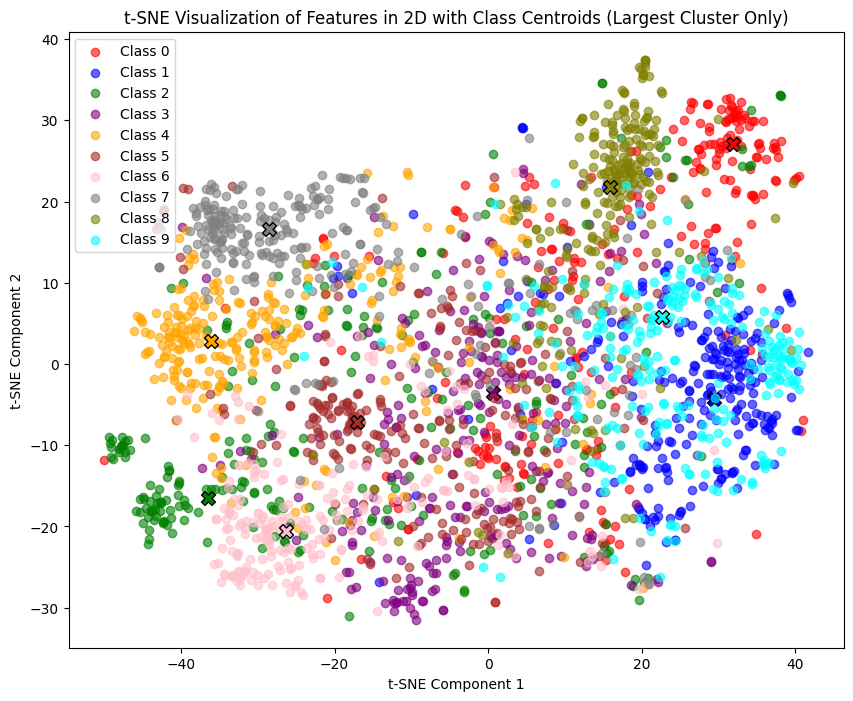

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# Load the data from the provided path
path = r'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_19_data.tar.pkl'
with open(path, 'rb') as f:
    loaded_data = pickle.load(f)
    features = loaded_data['features']
    targets = loaded_data['targets']

# Apply t-SNE to reduce dimensions to 2 for visualization
tsne_model = TSNE(n_components=2, random_state=42)
tsne_results = tsne_model.fit_transform(features)

# Define 10 distinct colors for each class
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Function to calculate adaptive `eps` based on k-nearest neighbors
def calculate_eps(data, k=5):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors.fit(data)
    distances, _ = neighbors.kneighbors(data)
    avg_distance = np.mean(distances[:, -1])  # Average of the k-th neighbor distance
    return avg_distance

# Plot the 2D t-SNE results with distinct colors per class
plt.figure(figsize=(10, 8))
for class_id in np.unique(targets):
    class_points = tsne_results[targets == class_id]
    adaptive_eps = calculate_eps(class_points, k=5)
    min_samples = max(5, int(0.01 * len(class_points)))
    dbscan = DBSCAN(eps=adaptive_eps, min_samples=min_samples)
    labels = dbscan.fit_predict(class_points)
    unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
    if len(unique_labels) > 0:
        largest_cluster_label = unique_labels[np.argmax(counts)]
        largest_cluster_points = class_points[labels == largest_cluster_label]
    else:
        largest_cluster_points = class_points

    plt.scatter(class_points[:, 0], class_points[:, 1], color=colors[class_id], label=f'Class {class_id}', alpha=0.6)
    centroid = largest_cluster_points.mean(axis=0)
    plt.scatter(centroid[0], centroid[1], color=colors[class_id], edgecolor='black', s=100, marker='X')

plt.title("t-SNE Visualization of Features in 2D with Class Centroids (Largest Cluster Only)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()


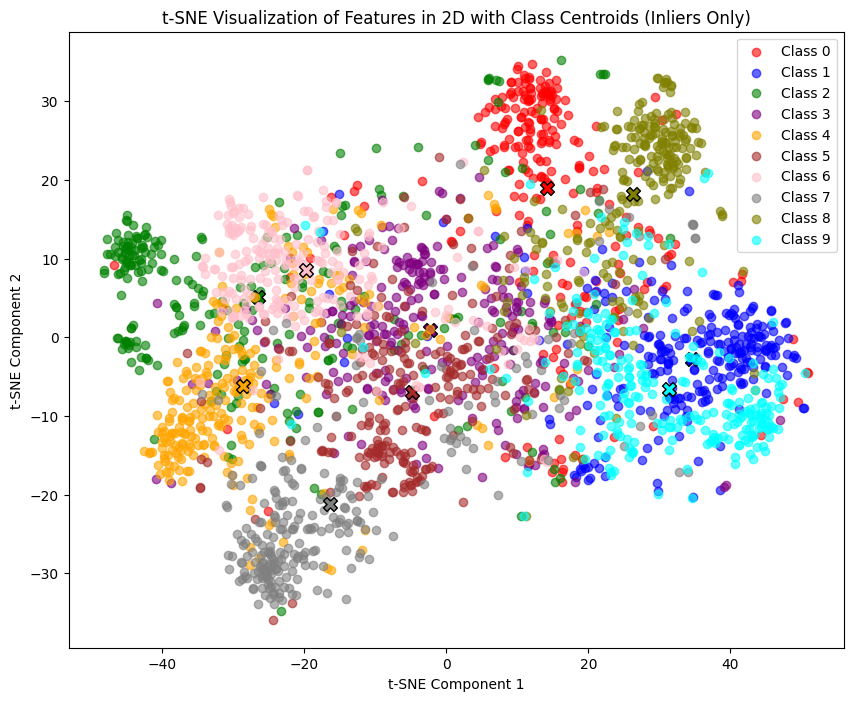

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest

# Load the data from the provided path
path = r'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_11_data.tar.pkl'
with open(path, 'rb') as f:
    loaded_data = pickle.load(f)
    features = loaded_data['features']
    targets = loaded_data['targets']

# Apply t-SNE to reduce dimensions to 2 for visualization
tsne_model = TSNE(n_components=2, random_state=42)
tsne_results = tsne_model.fit_transform(features)

# Define 10 distinct colors for each class
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Plot the 2D t-SNE results with distinct colors per class
plt.figure(figsize=(10, 8))

for class_id in np.unique(targets):
    # Filter points belonging to the current class
    class_points = tsne_results[targets == class_id]

    # Use Isolation Forest to detect inliers (label 1) and outliers (label -1)
    isolation_forest = IsolationForest(contamination=0.05, random_state=42)  # Set contamination as needed
    labels = isolation_forest.fit_predict(class_points)

    # Select only inliers for centroid calculation
    inliers = class_points[labels == 1]

    # Plot all points for the current class
    plt.scatter(class_points[:, 0], class_points[:, 1], color=colors[class_id], label=f'Class {class_id}', alpha=0.6)

    # Calculate and plot the centroid of the inliers
    centroid = inliers.mean(axis=0)
    plt.scatter(centroid[0], centroid[1], color=colors[class_id], edgecolor='black', s=100, marker='X')

plt.title("t-SNE Visualization of Features in 2D with Class Centroids (Inliers Only)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()


## **Saving 20 models to pickles:**

In [ ]:
import pickle
import numpy as np
import torch
from sklearn.metrics import accuracy_score

# Helper function to load data
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    features = data['features']
    if 'targets' in data:  # Labeled data
        targets = data['targets']
        targets = targets.clone().detach() if isinstance(targets, torch.Tensor) else torch.tensor(targets, dtype=torch.long)
    else:  # Unlabeled data
        targets = None
    return features, targets

# Modified LwP model training function with Gaussian noise
def train_lwp_hard(features, targets, regularization=1e-2, prototype_smoothing=0.2, noise_std=0.1):
    num_classes = 10
    prototypes = []
    cov_matrices = []
    global_mean = features.mean(axis=0)

    for i in range(num_classes):
        # Add Gaussian noise to the features of each class
        class_features = features[targets == i]
        noisy_class_features = class_features + np.random.normal(0, noise_std, class_features.shape)

        # Prototype smoothing with global mean and noisy class mean
        prototype = (1 - prototype_smoothing) * noisy_class_features.mean(axis=0) + prototype_smoothing * global_mean
        prototypes.append(prototype)

        # Regularized covariance matrix
        cov_matrix = np.cov(noisy_class_features, rowvar=False) + regularization * np.eye(class_features.shape[1])
        cov_matrices.append(np.linalg.inv(cov_matrix))

    return np.array(prototypes), cov_matrices

# LwP model training function with soft clustering and progressive prototypes averaging
def train_lwp_soft(features, prev_prototypes=None, prev_cov_matrices=None, alpha=0.5, num_classes=10):
    prototypes = []
    cov_matrices = []

    # Compute soft assignments z_nk for each data point and each cluster
    soft_assignments = np.zeros((features.shape[0], num_classes))
    epsilon = 1e-12  # Small value to avoid division by zero

    for k in range(num_classes):
        distances = np.linalg.norm(features - prev_prototypes[k], axis=1) ** 2
        soft_assignments[:, k] = np.exp(-distances)

    # Add epsilon to avoid division by zero and normalize
    soft_assignments_sum = soft_assignments.sum(axis=1, keepdims=True) + epsilon
    soft_assignments /= soft_assignments_sum

    for k in range(num_classes):
        # Update prototype (mean) with soft assignments
        weighted_sum = np.sum(soft_assignments[:, k][:, np.newaxis] * features, axis=0)
        total_weight = np.sum(soft_assignments[:, k])

        # Check if total_weight is zero to avoid division by zero
        if total_weight > 0:
            prototype = weighted_sum / total_weight
        else:
            # If total_weight is zero, retain previous prototype or use feature mean
            prototype = prev_prototypes[k] if prev_prototypes is not None else np.mean(features, axis=0)

        # Progressive averaging with previous prototype
        prototype = alpha * prototype + (1 - alpha) * prev_prototypes[k]
        prototypes.append(prototype)

        # Update covariance matrix with soft assignments
        cov_matrix = np.zeros((features.shape[1], features.shape[1]))
        for n in range(features.shape[0]):
            diff = (features[n] - prototype).reshape(-1, 1)
            cov_matrix += soft_assignments[n, k] * (diff @ diff.T)
        if total_weight > 0:
            cov_matrix /= total_weight
        else:
            cov_matrix = np.cov(features, rowvar=False) + np.eye(features.shape[1]) * 1e-6  # Use feature covariance as fallback

        # Progressive averaging with previous covariance matrix
        cov_matrix = alpha * cov_matrix + (1 - alpha) * np.linalg.inv(prev_cov_matrices[k])
        cov_matrices.append(np.linalg.inv(cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-6))  # Add small value for stability

    return np.array(prototypes), cov_matrices


# Prediction function using Mahalanobis distance
def predict_lwp(features, prototypes, cov_matrices):
    predictions = []
    for feature in features:
        distances = []
        for i in range(len(prototypes)):
            diff = feature - prototypes[i]
            mah_dist = np.sqrt(diff.T @ cov_matrices[i] @ diff)
            distances.append(mah_dist)
        predicted_class = np.argmin(distances)
        predictions.append(predicted_class)
    return predictions


# Paths for datasets (adjust paths as needed)
dataset_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 21)]
heldout_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 21)]

# Initialize variables
models = []  # To store each trained model (prototypes and cov_matrices)
accuracy_matrix = np.zeros((20, 20))  # Accuracy matrix for each model on held-out datasets

# Step 1: Train initial model f1 on D1 using hard clustering with regularization and prototype smoothing
features, targets = load_data(dataset_paths[0])
prototypes, cov_matrices = train_lwp_hard(features, targets, regularization=1, prototype_smoothing=0.2)
models.append((prototypes, cov_matrices))

# Save the model's prototypes and covariance matrix
with open(f'model_1.pkl', 'wb') as f:
    pickle.dump({'prototypes': prototypes, 'cov_matrices': cov_matrices}, f)

# Step 2: Iteratively update models f2 to f20 using Progressive Prototypes Averaging with soft clustering
for i in range(1, 20):
    features, _ = load_data(dataset_paths[i])
    # Retrain LwP with progressive prototype averaging and soft clustering
    prototypes, cov_matrices = train_lwp_soft(features, prev_prototypes=models[-1][0], prev_cov_matrices=models[-1][1], alpha=0.2)
    models.append((prototypes, cov_matrices))

    # Save each model's prototypes and covariance matrix
    with open(f'model_{i+1}.pkl', 'wb') as f:
        pickle.dump({'prototypes': prototypes, 'cov_matrices': cov_matrices}, f)

    print(f"Update of model done using Dataset-{i+1}")

# Step 3: Evaluate each model on the held-out datasets and fill in the accuracy matrix
for i, (prototypes, cov_matrices) in enumerate(models):
    for j in range(i + 1):
        heldout_features, heldout_targets = load_data(heldout_paths[j])
        heldout_predictions = predict_lwp(heldout_features, prototypes, cov_matrices)
        accuracy = accuracy_score(heldout_targets.numpy(), heldout_predictions)
        accuracy_matrix[i, j] = accuracy * 100  # Store accuracy as percentage
    print(accuracy_matrix)
    print(f"Evaluation of model{i+1} done!")

# Print accuracy matrix
print("Accuracy Matrix (Rows: Models f1 to f20, Columns: Held-out datasets D1 to D20):")
print(accuracy_matrix)


Update of model done using Dataset-2
Update of model done using Dataset-3
Update of model done using Dataset-4
Update of model done using Dataset-5
Update of model done using Dataset-6
Update of model done using Dataset-7
Update of model done using Dataset-8
Update of model done using Dataset-9
Update of model done using Dataset-10
Update of model done using Dataset-11
Update of model done using Dataset-12
Update of model done using Dataset-13
Update of model done using Dataset-14
Update of model done using Dataset-15
Update of model done using Dataset-16
Update of model done using Dataset-17
Update of model done using Dataset-18
Update of model done using Dataset-19
Update of model done using Dataset-20
[[99.96  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0

## **Task-2 NN:**

In [ ]:
import pickle
import numpy as np
import torch
from sklearn.metrics import accuracy_score

# Helper function to load data
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    features = data['features']
    if 'targets' in data:  # Labeled data
        targets = data['targets']
        targets = targets.clone().detach() if isinstance(targets, torch.Tensor) else torch.tensor(targets, dtype=torch.long)
    else:  # Unlabeled data
        targets = None
    return features, targets

# Modified LwP model training function with Gaussian noise
def train_lwp_hard(features, targets, regularization=1e-2, prototype_smoothing=0.2, noise_std=0.1):
    num_classes = 10
    prototypes = []
    cov_matrices = []
    global_mean = features.mean(axis=0)
    for i in range(num_classes):
        class_features = features[targets == i]
        noisy_class_features = class_features + np.random.normal(0, noise_std, class_features.shape)
        prototype = (1 - prototype_smoothing) * noisy_class_features.mean(axis=0) + prototype_smoothing * global_mean
        prototypes.append(prototype)
        cov_matrix = np.cov(noisy_class_features, rowvar=False) + regularization * np.eye(class_features.shape[1])
        cov_matrices.append(np.linalg.inv(cov_matrix))
    return np.array(prototypes), cov_matrices

# LwP model training function with soft clustering and progressive prototypes averaging
from sklearn.cluster import KMeans
import numpy as np

# LwP model training function using KMeans with initialization from previous prototypes
import numpy as np

import numpy as np

def train_lwp_soft(features, prev_prototypes, prev_cov_matrices, alpha=0.2, num_classes=10):
    prototypes = []
    cov_matrices = []
    selected_points = {i: [] for i in range(num_classes)}

    # Step 1: Predict labels and confidence using Mahalanobis distance
    distances = []
    for feature in features:
        feature_distances = []
        for i in range(num_classes):
            diff = feature - prev_prototypes[i]
            mah_dist = np.sqrt(diff.T @ prev_cov_matrices[i] @ diff)
            feature_distances.append(mah_dist)
        distances.append(feature_distances)

    distances = np.array(distances)
    predicted_labels = np.argmin(distances, axis=1)
    confidence_scores = np.min(distances, axis=1)

    # Step 2: Collect top 50% most confident points per class
    for k in range(num_classes):
        class_points = features[predicted_labels == k]
        class_confidences = confidence_scores[predicted_labels == k]
        if len(class_confidences) > 0:
            top_indices = np.argsort(class_confidences)[: len(class_confidences) // 2]
            selected_points[k] = class_points[top_indices]

    # Step 3: Compute new prototypes and covariance matrices using top 50% confident points
    for k in range(num_classes):
        class_features = selected_points[k]

        if len(class_features) == 0:
            # Use previous prototype and covariance matrix if no confident points
            prototype = prev_prototypes[k]
            cov_matrix = np.linalg.inv(prev_cov_matrices[k])
        else:
            prototype = alpha * class_features.mean(axis=0) + (1 - alpha) * prev_prototypes[k]
            cov_matrix = np.cov(class_features, rowvar=False) + np.eye(features.shape[1]) * 1e-6  # Regularization term

            # Blend current covariance with previous one
            cov_matrix = alpha * cov_matrix + (1 - alpha) * np.linalg.inv(prev_cov_matrices[k])

        # Ensure covariance matrix is invertible by adding a small regularization term
        cov_matrices.append(np.linalg.inv(cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-6))
        prototypes.append(prototype)

    return np.array(prototypes), cov_matrices



# Prediction function using Mahalanobis distance
def predict_lwp(features, prototypes, cov_matrices):
    predictions = []
    for feature in features:
        distances = []
        for i in range(len(prototypes)):
            diff = feature - prototypes[i]
            mah_dist = np.sqrt(diff.T @ cov_matrices[i] @ diff)
            distances.append(mah_dist)
        predicted_class = np.argmin(distances)
        predictions.append(predicted_class)
    return predictions

def load_model(num):
    with open(fr'/content/drive/MyDrive/ML_Mini_Project_2/models/model_{num}.pkl', 'rb') as f:
        data = pickle.load(f)
    prototypes = data['prototypes']
    cov_matrices = data['cov_matrices']
    return prototypes, cov_matrices


# Paths for datasets (adjust paths as needed)
dataset_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 21)]
heldout_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/Extracted_Features_Part_One/extracted_features_{i}_data.tar.pkl' for i in range(1, 21)]
model_paths = [fr'/content/drive/MyDrive/ML_Mini_Project_2/models/model_{i}.pkl' for i in range(1, 21)]

# Initialize variables
models = []  # To store each trained model (prototypes and cov_matrices)

for i in range(0, 10):
    prototypes, cov_matrices = load_model(i+1)
    models.append((prototypes, cov_matrices))
    print(f"Update of model done using Dataset-{i+1}")

for i in range(10, 20):
    features, _ = load_data(dataset_paths[i])
    prototypes, cov_matrices = train_lwp_soft(features, prev_prototypes=models[-1][0], prev_cov_matrices=models[-1][1], alpha=0.3)
    models.append((prototypes, cov_matrices))
    print(f"Update of model done using Dataset-{i+1}")

accuracy_matrix = np.zeros((20, 20))  # Accuracy matrix for each model on held-out datasets
for i in range(10, len(models)):
    prototypes, cov_matrices = models[0]
    for j in range(i + 1):
        heldout_features, heldout_targets = load_data(heldout_paths[j])
        heldout_predictions = predict_lwp(heldout_features, prototypes, cov_matrices)
        accuracy = accuracy_score(heldout_targets.numpy(), heldout_predictions)
        accuracy_matrix[i, j] = accuracy * 100  # Store accuracy as percentage
    print(accuracy_matrix)
    print(f"Evaluation of model {i+1} done!")

import pandas as pd
model_names = [f"Model f{i+1}" for i in range(20)]
dataset_names = [f"Dataset D{j+1}" for j in range(20)]
accuracy_df = pd.DataFrame(accuracy_matrix, index=model_names, columns=dataset_names)
print("Accuracy Matrix (Rows: Models f1 to f20, Columns: Held-out datasets D1 to D20):")
print(accuracy_df)

Update of model done using Dataset-1
Update of model done using Dataset-2
Update of model done using Dataset-3
Update of model done using Dataset-4
Update of model done using Dataset-5
Update of model done using Dataset-6
Update of model done using Dataset-7
Update of model done using Dataset-8
Update of model done using Dataset-9
Update of model done using Dataset-10
Update of model done using Dataset-11
Update of model done using Dataset-12
Update of model done using Dataset-13
Update of model done using Dataset-14
Update of model done using Dataset-15
Update of model done using Dataset-16
Update of model done using Dataset-17
Update of model done using Dataset-18
Update of model done using Dataset-19
Update of model done using Dataset-20
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 

KeyboardInterrupt: 

In [ ]:
from torchvision import models

resnet_model = models.resnet18(pretrained=True)  #Loading pretrained latest resnet model
resnet_model.fc = torch.nn.Identity()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
